In [11]:
# imports
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [12]:
# Notebook variables
SEED_VALUE = 72
TRAIN_SIZE = 0.8
TEST_SIZE = 0.2

trainDataPath = "../input/train.csv"

In [13]:
# Functions

# Plot mutual information data
def plot_mi_scores(scores, axis, title):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    axis.barh(width, scores)
    axis.set_yticks(width, ticks)
    axis.set_title(title)

# Function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid, n_estimators=100, max_depth=3):
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=SEED_VALUE, max_depth=max_depth)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds), accuracy_score(y_valid, preds)

In [14]:
# Load initial data

rawData = pd.read_csv(trainDataPath, index_col="PassengerId")
rawTargetData = rawData.Survived
rawTrainData = rawData.drop(["Survived"], axis=1)

trainData, validationData, trainTarget, validationTarget = train_test_split(rawTrainData, rawTargetData, train_size=TRAIN_SIZE, test_size=TEST_SIZE, random_state=SEED_VALUE)

print("Training data:")
print(trainData.info())

print("Validation data:")
print(validationData.info())

print("Training targets:")
print(trainTarget.info())

print("Validation targets:")
print(validationTarget.info())


Training data:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 293 to 473
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    712 non-null    int64  
 1   Name      712 non-null    object 
 2   Sex       712 non-null    object 
 3   Age       573 non-null    float64
 4   SibSp     712 non-null    int64  
 5   Parch     712 non-null    int64  
 6   Ticket    712 non-null    object 
 7   Fare      712 non-null    float64
 8   Cabin     162 non-null    object 
 9   Embarked  711 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 61.2+ KB
None
Validation data:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 10 to 802
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    179 non-null    int64  
 1   Name      179 non-null    object 
 2   Sex       179 non-null    object 
 3   Age       141 non-n

### Initial look at data

We have a few columns in the training set of data

- survival - the target variable. 1 for survived. 0 for did not survive.
- pclass - the ticket class. Likely useful for prediction
- sex - sex. Likely useful for prediction. Convert to 0/1
- age - age. This may be useful but there are some values missing. Will need to decide on a method to fill in those missing values
- sibsp - number of siblings and spouses on board. Will need to investigate to see if this is useful.
- parch - number of parents and children on board. Will need to investigate to see if this is useful.
- ticket - ticket number. Not sure if this will be very useful. Many missing and not a standard pattern. Will ignore initially.
- Fare - cost of fare. Unsure of this will be useful or not and may share information with pclass. Can investigate to see if useful.
- Cabin - the cabin number. Many missing and pclass, fare probably have the same/more info. Will ignore initially.
- Embarked - where the person got on. Three values so will need to one-hot encode it and will see if it's useful.

### Pre-process training data

We will remove:

- passengerId - not required
- age (we will initially drop this and look at adding it back in later with some missing data estimates)
- ticket
- cabin

We will convert:

- sex - one-hot encoding
- embarked - one-hot encoding


In [15]:
# Preprocessing - everything one-hot

ppData = trainData.copy()

# One-hot encode category columns
categoryColumns = ["Sex", "Embarked"]
ohEncoder = OneHotEncoder(handle_unknown = "ignore", sparse = False, dtype="int")
encodedTrain = pd.DataFrame(ohEncoder.fit_transform(trainData[categoryColumns]))
encodedTrain.index = trainData.index

ppData = pd.concat([ppData, encodedTrain], axis=1)

# Drop unwanted columns
ppData = ppData.drop(["Age", "Ticket", "Cabin", "Name"], axis=1)

# Drop category columns
ppData = ppData.drop(categoryColumns, axis=1)

print(ppData.info())

ppData.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 293 to 473
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pclass  712 non-null    int64  
 1   SibSp   712 non-null    int64  
 2   Parch   712 non-null    int64  
 3   Fare    712 non-null    float64
 4   0       712 non-null    int32  
 5   1       712 non-null    int32  
 6   2       712 non-null    int32  
 7   3       712 non-null    int32  
 8   4       712 non-null    int32  
 9   5       712 non-null    int32  
dtypes: float64(1), int32(6), int64(3)
memory usage: 44.5 KB
None


,Pclass,SibSp,Parch,Fare,0,1,2,3,4,5
PassengerId,,,,,,,,,,
293,2,0,0,12.8750,0,1,1,0,0,0
675,2,0,0,0.0000,0,1,0,0,1,0
122,3,0,0,8.0500,0,1,0,0,1,0
7,1,0,0,51.8625,0,1,0,0,1,0
781,3,0,0,7.2292,1,0,1,0,0,0


In [16]:
# Preprocessing - sex to int

pp2Data = trainData.copy()

# One-hot encode category columns
categoryColumns = ["Embarked"]
ohEncoder = OneHotEncoder(handle_unknown = "ignore", sparse = False, dtype="int")
encodedTrain = pd.DataFrame(ohEncoder.fit_transform(trainData[categoryColumns]))
encodedTrain.index = trainData.index

ordinalColumns = ["Sex"]
ordEncoder2 = OrdinalEncoder()
pp2Data[ordinalColumns] = ordEncoder2.fit_transform(trainData[ordinalColumns])

pp2Data = pd.concat([pp2Data, encodedTrain], axis=1)

# Drop unwanted columns
pp2Data = pp2Data.drop(["Age", "Ticket", "Cabin", "Name"], axis=1)

# Drop category columns
pp2Data = pp2Data.drop(categoryColumns, axis=1)

print(pp2Data.info())

pp2Data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 293 to 473
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pclass  712 non-null    int64  
 1   Sex     712 non-null    float64
 2   SibSp   712 non-null    int64  
 3   Parch   712 non-null    int64  
 4   Fare    712 non-null    float64
 5   0       712 non-null    int32  
 6   1       712 non-null    int32  
 7   2       712 non-null    int32  
 8   3       712 non-null    int32  
dtypes: float64(2), int32(4), int64(3)
memory usage: 44.5 KB
None


,Pclass,Sex,SibSp,Parch,Fare,0,1,2,3
PassengerId,,,,,,,,,
293,2,1.0,0,0,12.8750,1,0,0,0
675,2,1.0,0,0,0.0000,0,0,1,0
122,3,1.0,0,0,8.0500,0,0,1,0
7,1,1.0,0,0,51.8625,0,0,1,0
781,3,0.0,0,0,7.2292,1,0,0,0


In [17]:
# Preprocessing - ordinal for everything

pp3Data = trainData.copy()

ordinalColumns = ["Sex", "Embarked"]
pp3Data["Embarked"] = pp3Data["Embarked"].fillna("Unknown")

ordEncoder3 = OrdinalEncoder()
pp3Data[ordinalColumns] = ordEncoder3.fit_transform(pp3Data[ordinalColumns])

# Drop unwanted columns
pp3Data = pp3Data.drop(["Age", "Ticket", "Cabin", "Name"], axis=1)

print(pp3Data.info())

pp3Data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 293 to 473
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    712 non-null    int64  
 1   Sex       712 non-null    float64
 2   SibSp     712 non-null    int64  
 3   Parch     712 non-null    int64  
 4   Fare      712 non-null    float64
 5   Embarked  712 non-null    float64
dtypes: float64(3), int64(3)
memory usage: 38.9 KB
None


,Pclass,Sex,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,
293,2,1.0,0,0,12.8750,0.0
675,2,1.0,0,0,0.0000,2.0
122,3,1.0,0,0,8.0500,2.0
7,1,1.0,0,0,51.8625,2.0
781,3,0.0,0,0,7.2292,0.0


### Mutual information

Do some basic mutual information investigation.

From this initial look, it appears that `Sex` is the most important factor, followed by `Fare` and then `Pclass`
For our initial model, we will look at using those features only.

It also appears that straight ordinal encoding works well enough.


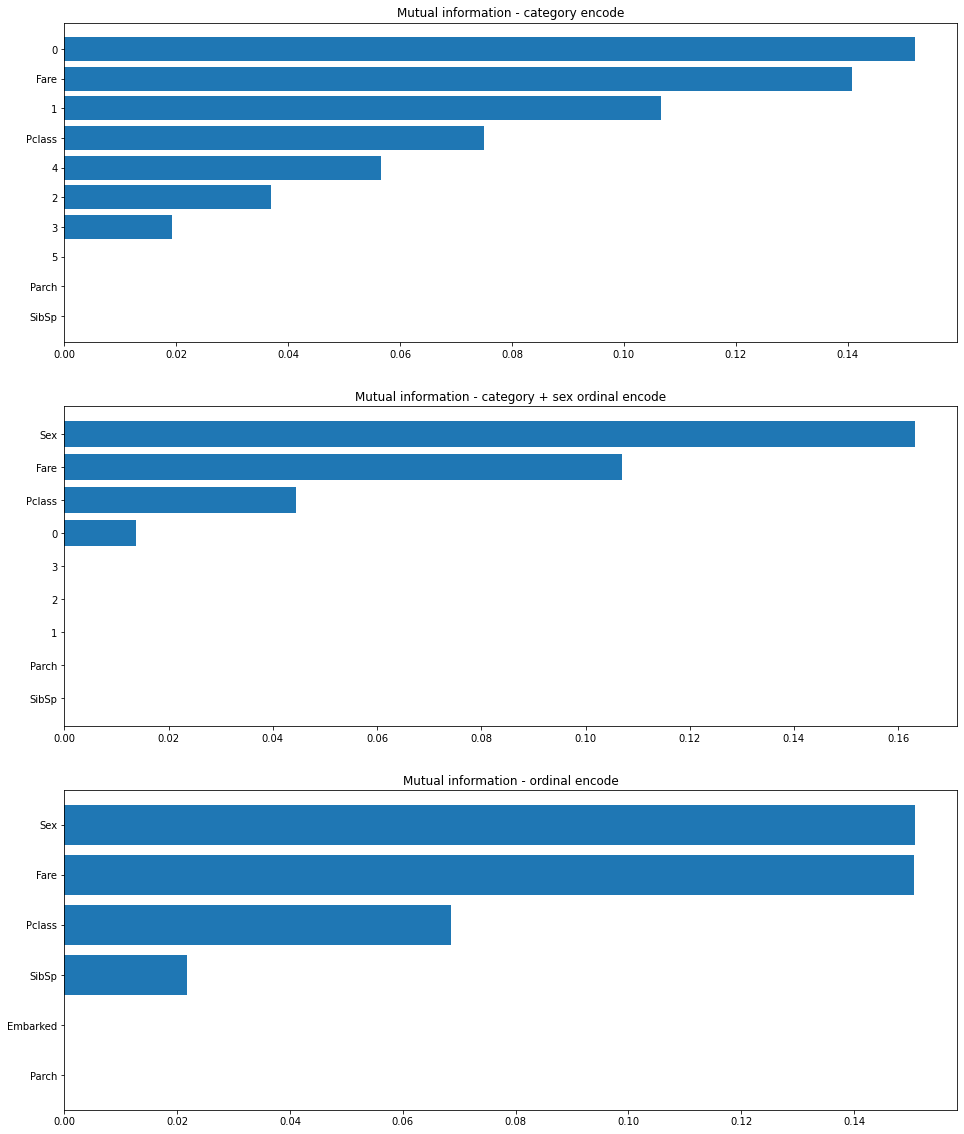

In [18]:
# Mutual info

miData = ppData.copy()
mi2Data = pp2Data.copy()
mi3Data = pp3Data.copy()

miScores = pd.Series(mutual_info_regression(miData, trainTarget, random_state=SEED_VALUE), name="MI Scores", index=miData.columns)
mi2Scores = pd.Series(mutual_info_regression(mi2Data, trainTarget, random_state=SEED_VALUE), name="MI Scores", index=mi2Data.columns)
mi3Scores = pd.Series(mutual_info_regression(mi3Data, trainTarget, random_state=SEED_VALUE), name="MI Scores", index=mi3Data.columns)


fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(16,20))
plot_mi_scores(miScores, ax1, "Mutual information - category encode")
plot_mi_scores(mi2Scores, ax2, "Mutual information - category + sex ordinal encode")
plot_mi_scores(mi3Scores, ax3, "Mutual information - ordinal encode")

### Creating model

Our first attempt at creating a model will use `Sex`, `Fare` and `Pclass`.

In [20]:
# Attempt 1

attempt1Train = pp2Data.copy()

requiredColumns = ["Sex", "Pclass"]
ordinalColumns = ["Sex"]

attempt1Train = attempt1Train[requiredColumns]

attempt1Valid = validationData[requiredColumns]
attempt1Valid[ordinalColumns] = ordEncoder2.transform(validationData[ordinalColumns])

estimators = [10, 50, 100, 200, 500, 1000]
depth = [1, 3, 5, 7, 9, 10, 20]

for d in depth:
  for e in estimators:
      attempt1MAE, attempt1Accuracy = score_dataset(attempt1Train, attempt1Valid, trainTarget, validationTarget, e, d)

      print("Estimators: <{0}>. Max depth: <{1}>. MAE: <{2}>. Accuracy: <{3}>".format(e, d, attempt1MAE, attempt1Accuracy))


C:\Users\sambe\AppData\Local\Temp\ipykernel_11788\2864373278.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  attempt1Valid[ordinalColumns] = ordEncoder2.transform(validationData[ordinalColumns])


Estimators: <10>. Max depth: <1>. MAE: <0.2346368715083799>. Accuracy: <0.7653631284916201>
Estimators: <50>. Max depth: <1>. MAE: <0.2346368715083799>. Accuracy: <0.7653631284916201>
Estimators: <100>. Max depth: <1>. MAE: <0.2346368715083799>. Accuracy: <0.7653631284916201>
Estimators: <200>. Max depth: <1>. MAE: <0.18435754189944134>. Accuracy: <0.8156424581005587>
Estimators: <500>. Max depth: <1>. MAE: <0.2346368715083799>. Accuracy: <0.7653631284916201>
Estimators: <1000>. Max depth: <1>. MAE: <0.2346368715083799>. Accuracy: <0.7653631284916201>
Estimators: <10>. Max depth: <3>. MAE: <0.2346368715083799>. Accuracy: <0.7653631284916201>
Estimators: <50>. Max depth: <3>. MAE: <0.2346368715083799>. Accuracy: <0.7653631284916201>
Estimators: <100>. Max depth: <3>. MAE: <0.2346368715083799>. Accuracy: <0.7653631284916201>
Estimators: <200>. Max depth: <3>. MAE: <0.2346368715083799>. Accuracy: <0.7653631284916201>
Estimators: <500>. Max depth: <3>. MAE: <0.2346368715083799>. Accuracy: 